In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# %reload_ext spaudiopy
import spaudiopy as spa

In [2]:
# Publication stuff
default_figsize = (3.39, 3.0)
plt.rcParams['figure.figsize'] = default_figsize
font = {'family' : 'serif',
        'size'   : 9}
plt.rc('font', **font)
plt.rcParams['axes.titlesize'] = 9

Parameters

In [3]:
N_sph = 2
shtype = 'real'

ENREC = True  # amplitude or energy reconstruction
pattern = "maxRE"

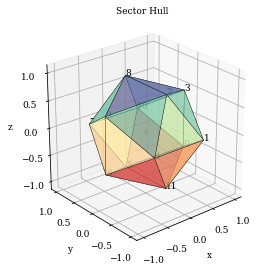

In [4]:
# steering of sectors
N_sph_sec = N_sph
sec_vecs = spa.grids.load_t_design(2*N_sph_sec if ENREC else N_sph_sec+1)  # N+1 or 2N
sec_azi, sec_colat, _ = spa.utils.cart2sph(*sec_vecs.T)
# number of sectors
J_sec = len(sec_vecs)
spa.plots.hull(spa.decoder.get_hull(*sec_vecs.T), title="Sector Hull")
plt.gcf().set_size_inches(3.3, 3.5)
#plt.savefig('figs/hull.pdf')

Sector analysis matrix 
A_sec - consists of the stacked beamformers

In [5]:
if pattern.lower() == "cardioid":
    c_n = spa.sph.cardioid_modal_weights(N_sph_sec)
elif pattern.lower() == "hypercardioid":
    c_n = spa.sph.hypercardioid_modal_weights(N_sph_sec)
elif pattern.lower() == "maxre":
    c_n = spa.sph.maxre_modal_weights(N_sph_sec, True)  # works with amplitude compensation and without!
else:
    assert()
A_sec = spa.sph.repeat_per_order(c_n) * \
            spa.sph.sh_matrix(N_sph_sec, sec_azi, sec_colat, shtype).conj()

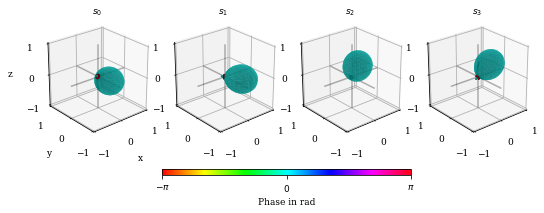

In [6]:
spa.plots.sh_coeffs_subplot([A_sec[0, :], A_sec[1, :],
                             A_sec[2, :], A_sec[3, :]],
                            titles=["$s_0$", "$s_1$", "$s_2$", "$s_3$"])
plt.gcf().set_size_inches(7, 3.5)

In [7]:
beta_a = np.sqrt(4*np.pi)/ (A_sec[0, 0] * J_sec)
beta_e = 1/ (A_sec[0, :].conj()@A_sec[0, :]/np.sqrt(4*np.pi) * J_sec/np.sqrt(4*np.pi))

Defining some input signal as a superposition of some patterns

In [8]:
# INPUT
Omega_in = np.c_[0, 0]
N_sph_in = N_sph
in_nm = spa.sph.sh_matrix(N_sph_in, Omega_in[:, 0], Omega_in[:, 1], shtype).conj()
in_nm = spa.sph.repeat_per_order(spa.sph.cardioid_modal_weights(N_sph_in)) * in_nm  # make cardioid
in_nm += spa.sph.sh_matrix(N_sph_in, Omega_in[:, 0]+np.pi/2, Omega_in[:, 1]+\
                           np.pi/2, shtype).conj()  # add another

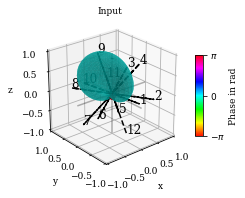

In [9]:
fig = plt.figure()
spa.plots.sh_coeffs(in_nm, title="Input", fig=fig)
ax = fig.gca()
ax.plot(np.insert(sec_vecs[:, 0], np.arange(J_sec), np.zeros(J_sec)),
           np.insert(sec_vecs[:, 1], np.arange(J_sec), np.zeros(J_sec)), 
           np.insert(sec_vecs[:, 2], np.arange(J_sec), np.zeros(J_sec)),
           color='black', linestyle='dashed')
for s, co in enumerate(sec_vecs):
    ax.text(co[0], co[1], co[2], s+1, zorder=1, fontsize=12)
plt.savefig('input_sec_nm.pdf')

Carry out sector analysis, producing sector signals

In [10]:
# Apply sectors
delta_numSH = (N_sph_in+1)**2 - (N_sph_sec+1)**2
pw_secs_out = np.c_[A_sec, np.zeros([J_sec, delta_numSH])].conj() @ in_nm.T
pw_secs_out = np.real_if_close(pw_secs_out)

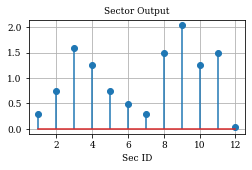

In [11]:
fig, ax = plt.subplots(figsize=(default_figsize[0], 3/4*default_figsize[1]), constrained_layout=True)
plt.stem(np.arange(J_sec)+1, pw_secs_out)
plt.xlabel("Sec ID")
plt.grid()
plt.title("Sector Output")
plt.savefig('sector_output.pdf')

Defining resynthesis matrix B

In [12]:
# Resynth
c_n_re = np.ones(N_sph_sec+1)
if ENREC:
    c_n_re = (1/(c_n/c_n[0]))
else:
    c_n_re = np.ones(N_sph_sec+1)
Y_resynth = spa.sph.sh_matrix(N_sph_sec, sec_azi, sec_colat, shtype)
B_resynth = spa.sph.repeat_per_order(c_n_re)*Y_resynth

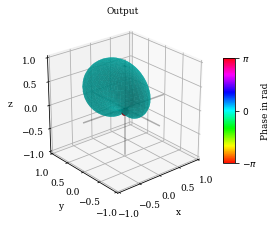

In [13]:
resynth_nm = (B_resynth.conj().T @ pw_secs_out).T
resynth_nm = beta_a * resynth_nm

spa.plots.sh_coeffs(np.c_[resynth_nm, np.zeros([1, delta_numSH])],
                    title=f"Output")

In [14]:
# little plot helper with some syntactic sugar
def plot_mats(*Ms, titles=None):
    assert(len(Ms) > 1)
    L = len(Ms)
    fig, axs = plt.subplots(1, L, constrained_layout=True)
    for ax, m_it in zip(axs, Ms):
        p = ax.matshow(m_it)
        cbar = axs[0].figure.colorbar(p, ax=ax, shrink=1/(L))
    if titles is not None:
        for it in range(L):
            axs[it].set_title(titles[it])

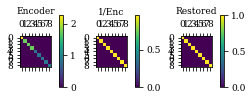

In [15]:
M1 = (spa.sph.sh_matrix(N_sph_sec, sec_azi, sec_colat, 'real')).T @ \
      (spa.sph.repeat_per_order(c_n) * spa.sph.sh_matrix(N_sph_sec, sec_azi, sec_colat, 'real'))
M2 = (spa.sph.repeat_per_order(1/(c_n)) * spa.sph.sh_matrix(N_sph_sec, sec_azi, sec_colat, 'real')).T @ \
      (spa.sph.repeat_per_order(c_n) * spa.sph.sh_matrix(N_sph_sec, sec_azi, sec_colat, 'real'))
M3 = (spa.sph.repeat_per_order((4*np.pi/J_sec)/(c_n)) * spa.sph.sh_matrix(N_sph_sec, sec_azi, sec_colat, 'real')).T @ \
      (spa.sph.repeat_per_order(c_n) * spa.sph.sh_matrix(N_sph_sec, sec_azi, sec_colat, 'real'))
plot_mats(M1, M2, M3, titles=["Encoder", "1/Enc", "Restored"])

In [16]:
# Isotropic noise input
# Evaluation
from numpy.random import default_rng
rng = default_rng()

fs = 48000
t_sig = 3
in_nm_diff = 1 * rng.standard_normal((t_sig*fs, (N_sph+1)**2))
in_nm_pw1 = 1 * rng.standard_normal((t_sig*fs, 1)) * spa.sph.sh_matrix(N_sph, sec_azi[0], sec_colat[0], shtype).conj()
in_nm_pw2 = 1 * rng.standard_normal((t_sig*fs, 1)) * spa.sph.sh_matrix(N_sph, sec_azi[2], sec_colat[2], shtype).conj()

in_nm = in_nm_diff # + in_nm_pw1 + in_nm_pw2
#in_nm = np.ones([1, (N_sph+1)**2])

In [17]:
def rms(X, axis=0):
    return np.sqrt(np.mean(np.square(np.abs(X)), axis=axis))

<StemContainer object of 3 artists>

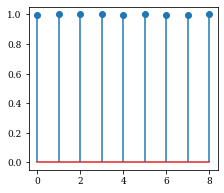

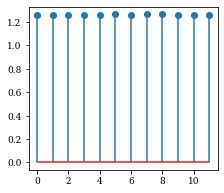

In [18]:
in_sec = (A_sec.conj() @ in_nm.T).T # discrete domain
plt.figure()
plt.stem(rms(in_nm))
plt.figure()
plt.stem(rms(in_sec))

In [19]:
def plot_sph_rms(F_nm):
    assert(F_nm.ndim == 2)
    grid_azi, grid_zen, grid_r = spa.utils.cart2sph(*spa.grids.load_n_design(40).T)
    # Looking with hyper-cardioids
    s_grid = F_nm @ ((4*np.pi)/((N_sph+1)**2) * spa.sph.sh_matrix(N_sph, grid_azi, grid_zen, shtype)).T
    s_rms = rms(s_grid, axis=0)  # why is this sqrt(4pi/nSH)?!
    print("RMS Mean: ", np.round(s_rms.mean(), 3))
    fig = plt.figure()
    spa.plots.spherical_function(s_rms, grid_azi, grid_zen, fig=fig)
    return s_rms.mean()

RMS Mean:  1.181


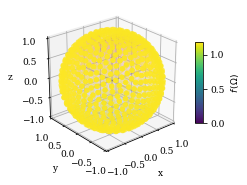

In [20]:
rms_in = plot_sph_rms(in_nm)
plt.savefig('input_RMS.pdf')

RMS Mean:  1.181
Testing perfect reconstruction:  -- Close enough.
RMSE in dB :  -255.45412145822408


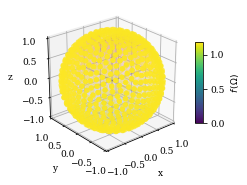

In [21]:
resynth_nm = (B_resynth.conj().T @ in_sec.T).T
resynth_nm = beta_a * resynth_nm
plot_sph_rms(resynth_nm)
spa.utils.test_diff(in_nm, resynth_nm, "Testing perfect reconstruction: ")
print('RMSE in dB : ', spa.utils.db(rms(resynth_nm.ravel()-in_nm.ravel())))

In [22]:
# Resynth based on sector rms and white noise
in_sec_rms = rms(in_sec)
in_sec_resynth = in_sec_rms * rng.standard_normal(in_sec.shape)
spa.utils.test_diff(in_sec_rms, rms(in_sec, axis=0))

Close enough.


0.0

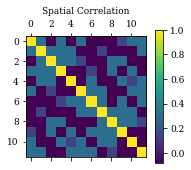

In [23]:
# Correlation matrix
Ys = spa.sph.sh_matrix(N_sph, sec_azi, sec_colat, 'real')
R = Ys @ np.diag(spa.sph.repeat_per_order(c_n))@ Ys.T
fig, ax = plt.subplots(figsize=(0.75*default_figsize[0], 0.75*default_figsize[1]), constrained_layout=True)
p = ax.matshow(R)
cbar = ax.figure.colorbar(p, ax=ax)
plt.title('Spatial Correlation')
plt.savefig('correlation_matrix.pdf')

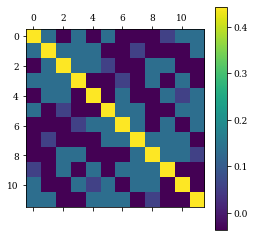

In [24]:
R = R / np.sum(R, axis=0)
plt.matshow(R)
plt.colorbar()


RMS Mean:  1.182


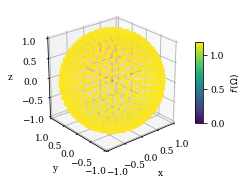

In [25]:
#resynth_nm = in_sec_resynth @ Y_resynth
resynth_nm = (B_resynth.conj().T @ (R @ in_sec_resynth.T)).T
resynth_nm = np.sqrt(beta_e) * resynth_nm
rms_out_en = plot_sph_rms(resynth_nm)

Testing energy Reconstruction:  -- Diff:  0.0011631183385061306
RMSE:  0.004251980764923418
RMSE in dB:  -47.42430862071876
Mean RMSE in dB from signals:  -63.92194042838865


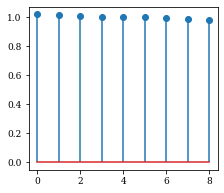

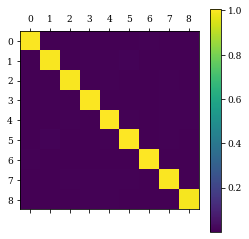

In [26]:
C_in = in_nm.conj().T @ in_nm / (fs * t_sig)
C_out = resynth_nm.conj().T @ resynth_nm / (fs * t_sig)
U, s, Vt = np.linalg.svd(C_out @ np.linalg.inv(C_in))
spa.utils.test_diff(1, np.mean(s), "Testing energy Reconstruction: ")
print("RMSE: ", rms((C_out @ np.linalg.inv(C_in)).ravel() - np.eye(*C_out.shape).ravel()))
print("RMSE in dB: ", spa.utils.db(rms(C_out.ravel() - C_in.ravel())))
print("Mean RMSE in dB from signals: ", spa.utils.db(rms_in - rms_out_en))

plt.stem(s)
plt.matshow(np.abs(C_out @ np.linalg.inv(C_in)))
plt.colorbar()


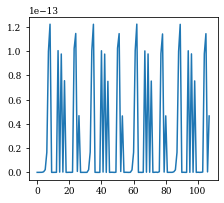

In [27]:
B_pinv = np.linalg.pinv(A_sec.conj().conj().T)
plt.plot(np.abs(B_pinv.ravel() - beta_a*B_resynth.ravel()))